# Imbalanced classes -- pic

What can we do if we have unbalanced classes, ie, if one class that is much rarer than the other, or if one class is more important to us than another?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("lecture.mplstyle")
import sklearn.datasets
import sklearn.utils
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

We download the [Lending Club Loan Dataset](https://www.openml.org/search?type=data&sort=runs&id=43729&status=active) from openml. It's a dataset on loans, the target variable captures whether the loan was fully paid back or not.

In [3]:
data=sklearn.datasets.fetch_openml(data_id=43729,target_column="not.fully.paid",parser='auto')

We split the data into a training set and a test set. At the same time we shuffle the data.

In [5]:
X_train,X_test,y_train,y_test=train_test_split(data.data,data.target,train_size=7000,shuffle=True)

Let's see whether we really have imbalanced classes:

In [6]:
sum(y_train==1),sum(y_train==0)

(1140, 5860)

Indeed, there are many more instances of class 0 (people paying back their loan) than instances of class 1 (people defaulting on their loan).

Let's have a peek at the training data:

Only a few -- that's good because that means we can one-hot encode the column (ie, replace the string values by unit vectors) without blowing up the dimensionality of the data. Because we only need to one-hot encode *one* column of the data, we wrap the <code>OneHotEncoder</code> into a <code>ColumnTransformer</code>, which then is applied to only the column <code>"purpose"</code>. 

For classification we use a simple classifier, namely a random forest. We could have chosen any other classifier as we're here only interested in demonstrating the effect of a class imbalance. Both the <code>OneHotEncoder</code> and <code>RandomForestClassifier</code> are merged to a <code>Pipeline</code>, an object hat looks from the outside like a simple classifier but that actually performs two steps, namely the transformation and the classification, every time <code>predict</code> (or <code>fit</code>) is called.

In [10]:
col_trans=make_column_transformer((OneHotEncoder(),['purpose']),remainder='passthrough')
rf=RandomForestClassifier()
classifier=Pipeline([('one hot',col_trans),('random forest',rf)])

We fit the whole pipeline.

In [11]:
classifier.fit(X_train,y_train)

Pipeline(steps=[('one hot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['purpose'])])),
                ('random forest', RandomForestClassifier())])

Let's check the accuracy.

In [12]:
y_pred=classifier.predict(X_test)
sklearn.metrics.accuracy_score(y_pred,y_test)

0.8463925523661753

Not great but respectable. However, as there are more instance of class 0, it's easy to achieve high accuracy by **always** predicting 0. So let's calculate the *true positive rate* (the fraction of positive instances that are recognised as positive) and the *true negative rate* (the fraction of negative instances that are recognised as negative).

Again, more formally, let's denote by
* *tp*: the number of instances of class 1 that are correctly predicted to be 1
* *fp*: the number of instances of class 0 that are incorrectly predicted to be 1
* *tn*: the number of instances of class 0 that are correctly predicted to be 0
* *fn*: the number of instances of class 1 that are incorrectly predicted to be 0
Then
$$ tpr=\frac{tp}{tp+fn} \text{ and } tnr=\frac{tn}{tn+fp}$$

In [13]:
tpr=sum(y_pred*y_test)/sum(y_test)
tnr=sum((1-y_pred)*(1-y_test))/sum(1-y_test)
tpr,tnr

(0.017811704834605598, 0.9954233409610984)

Aha. *True negative rate* is excellent: we detect almost all cases when a loan is paid back. *True positive rate*, however, is quite low -- we rarely detect a default on the loan. That is clearly bad.

To get a more complete picture we compute a *ROC curve*, a *Receiver operating characteristic* curve. (According to Wikipedia ROC curves where first conceived during World War II in the context of radar detection of enemy fighter planes, which may explain the weird name.) The ROC curve plots *false positive rate* against *true positive rate*, where *false positive rate* is the complement of *true negative rate*, ie, $fpr=1-tnr$. That means, ideally, we'd like *true positive rate* to be large and *false positive rate* to be small.

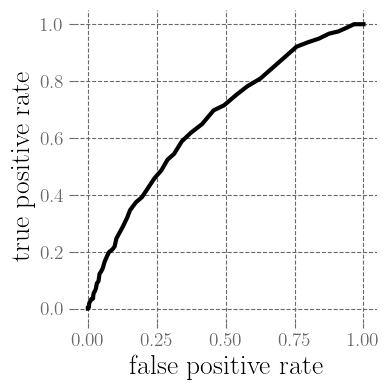

In [22]:
y_scores=classifier.predict_proba(X_test)[:,1]
fprs,tprs,thresholds=sklearn.metrics.roc_curve(y_test,y_scores,pos_label=1)

fig,ax=plt.subplots(figsize=(4,4))
ax.plot(fprs,tprs,"k-")
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
plt.tight_layout()
plt.savefig("roc.png",dpi=300)

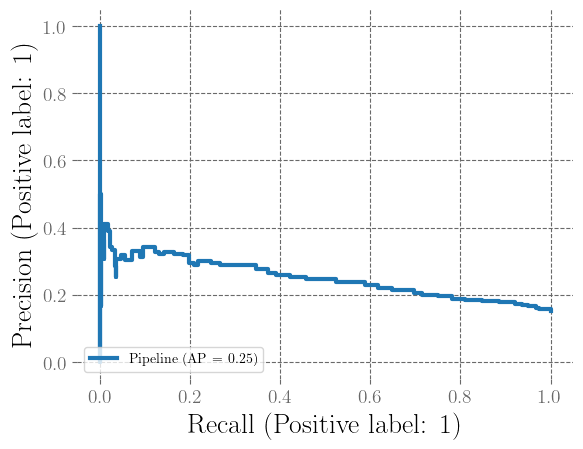

In [24]:
disp=sklearn.metrics.PrecisionRecallDisplay.from_estimator(classifier,X_test,y_test,pos_label=1)

In [25]:
precision,recall,thresholds=sklearn.metrics.precision_recall_curve(y_test,y_scores,pos_label=1)

In [26]:
precision

array([0.15244375, 0.15405723, 0.15701159, 0.15914684, 0.16173986,
       0.16572176, 0.16931457, 0.17424242, 0.17947447, 0.18200837,
       0.18510283, 0.1886121 , 0.19566603, 0.20081688, 0.20646583,
       0.21557828, 0.21982759, 0.22946176, 0.23692308, 0.23830735,
       0.24582339, 0.24708926, 0.25459689, 0.259375  , 0.26460481,
       0.27840909, 0.2893617 , 0.28767123, 0.29007634, 0.29494382,
       0.3003096 , 0.2885906 , 0.29602888, 0.31836735, 0.32300885,
       0.32828283, 0.32183908, 0.32704403, 0.34285714, 0.31147541,
       0.33018868, 0.30434783, 0.30379747, 0.31884058, 0.30645161,
       0.25454545, 0.28571429, 0.30232558, 0.33333333, 0.34375   ,
       0.39130435, 0.41176471, 0.30769231, 0.33333333, 0.36363636,
       0.16666667, 0.2       , 0.33333333, 0.5       , 0.        ,
       1.        ])

In [27]:
recall

array([1.        , 1.        , 1.        , 0.98727735, 0.97455471,
       0.96692112, 0.94910941, 0.93638677, 0.92111959, 0.88549618,
       0.84732824, 0.80916031, 0.78117048, 0.75063613, 0.71501272,
       0.69720102, 0.64885496, 0.61832061, 0.58778626, 0.54452926,
       0.52417303, 0.48600509, 0.45801527, 0.42239186, 0.39185751,
       0.3740458 , 0.34605598, 0.32061069, 0.29007634, 0.26717557,
       0.24681934, 0.21882952, 0.2086514 , 0.19847328, 0.18575064,
       0.1653944 , 0.14249364, 0.13231552, 0.1221374 , 0.09669211,
       0.08905852, 0.07124682, 0.0610687 , 0.05597964, 0.04834606,
       0.03562341, 0.03562341, 0.03307888, 0.03307888, 0.02798982,
       0.02290076, 0.0178117 , 0.01017812, 0.01017812, 0.01017812,
       0.00254453, 0.00254453, 0.00254453, 0.00254453, 0.        ,
       0.        ])

(-0.05, 1.05)

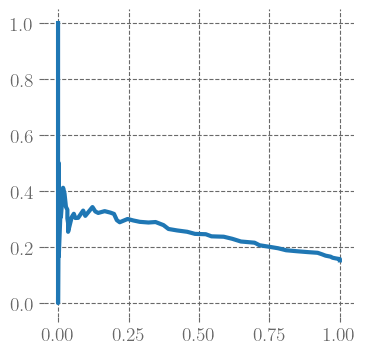

In [37]:
fig,ax=plt.subplots(figsize=(4,4))
#ax.plot(recall[:-10],precision[:-10])
ax.plot(recall,precision)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)